In [1]:
from modules.util import save_json, now
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
IMDB=pd.read_csv("./database/IMDB Dataset.csv")
IMDB

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [2]:
print(IMDB.describe())
print(IMDB.info())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


EDA 진행 결과 IMDB 데이터 셋의 열은 review와 sentiment로 구성,
각 열에 해당되는 행의 개수는 총 50000개이며 고유값들은 각각 49582개, 2개임.
이 리뷰를 lstm모델을 활용하여 긍정 혹은 부정으로 예측하는 모델을 구축할것임.

In [3]:
# 데이터 정제
duplicates = IMDB[IMDB.duplicated()]  
print("Duplicated Rows:\n", duplicates)

Duplicated Rows:
                                                   review sentiment
3537   Quite what the producers of this appalling ada...  negative
3769   My favourite police series of all time turns t...  positive
4391   Beautiful film, pure Cassavetes style. Gena Ro...  positive
6352   If you liked the Grinch movie... go watch that...  negative
6479   I want very much to believe that the above quo...  negative
...                                                  ...       ...
49912  This is an incredible piece of drama and power...  positive
49950  This was a very brief episode that appeared in...  negative
49984  Hello it is I Derrick Cannon and I welcome you...  negative
49986  This movie is a disgrace to the Major League F...  negative
49991  Les Visiteurs, the first movie about the medie...  negative

[418 rows x 2 columns]


In [4]:
IMDB = IMDB.drop_duplicates(subset='review') # 중복되는 행 제거
IMDB.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [5]:
IMDB.loc[:, 'sentiment']

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 49582, dtype: object

In [6]:
IMDB.loc[:, 'sentiment'] = IMDB['sentiment'].map({'positive': 1, 'negative': 0})
IMDB.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/trifull/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# NOTE: 텍스트 데이터 전처리
# 모델의 input을 효율적으로하고 정확한 성능을 내기 위해서 텍스트데이터를 일관된 형식으로 변환하는 과정이 필요함.
# 1. 텍스트 정규화 -> "특수문자", "대/소문자", "두 칸 이상의 공백" 제거 
# 2. 자연어 처리에서 큰 의미를 가지지 않는다고 알려져 있는 불용어(stopword) 제거 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import re
def clean_text(text):
    text = text.lower() # 소문자화
    text = re.sub(r"<.*?>", "", text) # HTML태그 제거 
    text = re.sub(r"[^.a-z\s!?']", "", text) # 특수 문자 및 숫자 제거
    text = " ".join(word for word in text.split() if word not in stop_words) # 불용어 제거
    text = re.sub(r'([!?\'"])\1+', r'\1', text) # !?'이 2개 이상이면 한 개로 만들어줌.
    text = re.sub(r'\s+', ' ', text).strip() # 불필요한 공백 제거
    return text
IMDB['review_cleaned'] = IMDB['review'].apply(clean_text)
# pd.Series([len(review) for review in IMDB["review_cleaned"].to_list()]).plot.hist(bins=50)

/tmp/ipykernel_3668755/1833480724.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IMDB['review_cleaned'] = IMDB['review'].apply(clean_text)


In [9]:
# 2. 토큰화
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
IMDB.loc[:,'review_tokenized'] = IMDB.loc[:,'review_cleaned'].apply(tokenizer.tokenize)
print(IMDB.head(3))

                                              review sentiment  \
0  One of the other reviewers has mentioned that ...         1   
1  A wonderful little production. <br /><br />The...         1   
2  I thought this was a wonderful way to spend ti...         1   

                                      review_cleaned  \
0  one reviewers mentioned watching oz episode ho...   
1  wonderful little production. filming technique...   
2  thought wonderful way spend time hot summer we...   

                                    review_tokenized  
0  [one, reviewers, mentioned, watching, oz, epis...  
1  [wonderful, little, production., filming, tech...  
2  [thought, wonderful, way, spend, time, hot, su...  


/tmp/ipykernel_3668755/2857127549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IMDB.loc[:,'review_tokenized'] = IMDB.loc[:,'review_cleaned'].apply(tokenizer.tokenize)


In [10]:
# 3. 단어집합 생성
import numpy as np
from nltk import FreqDist

all_tokens = np.hstack(IMDB["review_tokenized"])

# 단어 집합 생성 및 빈도 계산
vocab = FreqDist(all_tokens)
len(vocab)

238841

In [11]:
FREQ_THRESHOLD = 3
vocab = {key: value for key, value in vocab.items() if value >= FREQ_THRESHOLD}

# 단어와 인덱스 할당
# 단어 인덱스를 2부터 시작하여 word2idx 생성 -> 레이블 데이터를 1과 0으로 설정 했기 때문
word2idx = {word: idx + 2 for idx, (word, _) in enumerate(vocab.items())}
word2idx["<pad>"] = 0  # 패딩을 위한 인덱스 0 예약
word2idx["<unk>"] = 1  # 알 수 없는 단어를 위한 인덱스 1 예약
VOCAB_SIZE = len(word2idx)

VOCAB_SIZE, word2idx

(68505,
 {'one': 2,
  'reviewers': 3,
  'mentioned': 4,
  'watching': 5,
  'oz': 6,
  'episode': 7,
  'hooked.': 8,
  'right': 9,
  'exactly': 10,
  'happened': 11,
  'me.the': 12,
  'first': 13,
  'thing': 14,
  'struck': 15,
  'brutality': 16,
  'unflinching': 17,
  'scenes': 18,
  'violence': 19,
  'set': 20,
  'word': 21,
  'go.': 22,
  'trust': 23,
  'show': 24,
  'faint': 25,
  'hearted': 26,
  'timid.': 27,
  'pulls': 28,
  'punches': 29,
  'regards': 30,
  'drugs': 31,
  'sex': 32,
  'violence.': 33,
  'hardcore': 34,
  'classic': 35,
  'use': 36,
  'called': 37,
  'nickname': 38,
  'given': 39,
  'oswald': 40,
  'maximum': 41,
  'security': 42,
  'state': 43,
  'focuses': 44,
  'mainly': 45,
  'emerald': 46,
  'city': 47,
  'experimental': 48,
  'section': 49,
  'prison': 50,
  'cells': 51,
  'glass': 52,
  'fronts': 53,
  'face': 54,
  'privacy': 55,
  'high': 56,
  'agenda.': 57,
  'em': 58,
  'home': 59,
  'muslims': 60,
  'gangstas': 61,
  'latinos': 62,
  'christians': 63

In [12]:
IMDB['review_tokenized']

0        [one, reviewers, mentioned, watching, oz, epis...
1        [wonderful, little, production., filming, tech...
2        [thought, wonderful, way, spend, time, hot, su...
3        [basically, there, 's, family, little, boy, ja...
4        [petter, mattei, 's, love, time, money, visual...
                               ...                        
49995    [thought, movie, right, good, job., creative, ...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [catholic, taught, parochial, elementary, scho...
49998    [i, 'm, going, disagree, previous, comment, si...
49999    [one, expects, star, trek, movies, high, art, ...
Name: review_tokenized, Length: 49582, dtype: object

In [13]:
# 4. 맵핑(단어 집합을 데이터에 적용)
def word_to_num(word):
    try:
        return word2idx[word]  # 글자를 해당되는 정수로 변환
    except KeyError:  # 단어 집합에 없는 단어일 경우 unk로 대체된다.
        return word2idx["<unk>"]  # unk의 인덱스로 변환


IMDB["review_numbered"] = IMDB["review_tokenized"].apply(lambda _X: [word_to_num(word) for word in _X])
IMDB["token_length"] = IMDB["review_numbered"].apply(lambda _X: len(_X))

/tmp/ipykernel_3668755/191866984.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IMDB["review_numbered"] = IMDB["review_tokenized"].apply(lambda _X: [word_to_num(word) for word in _X])
/tmp/ipykernel_3668755/191866984.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IMDB["token_length"] = IMDB["review_numbered"].apply(lambda _X: len(_X))


<Axes: ylabel='Frequency'>

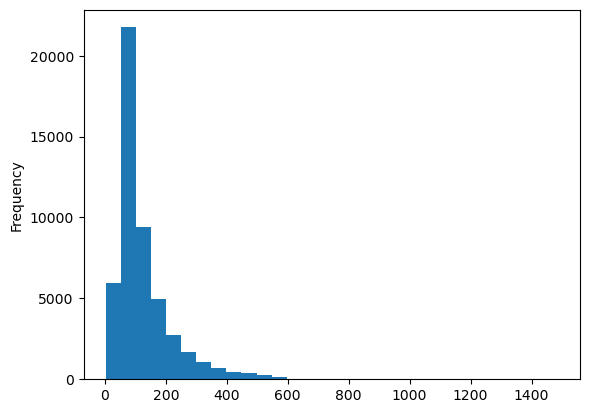

In [14]:
IMDB["token_length"].plot.hist(bins=30)

<Axes: ylabel='Frequency'>

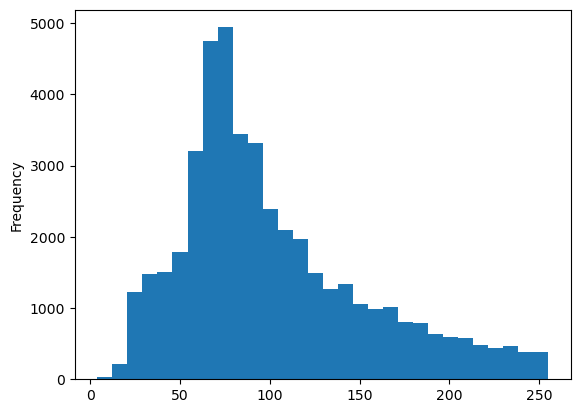

In [15]:
MAX_TOKEN = 256
IMDB_256 = IMDB[IMDB["token_length"]<MAX_TOKEN]
IMDB_256["token_length"].plot.hist(bins=30)

In [16]:
import torch
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
# Train Valid Test Split
from sklearn.model_selection import train_test_split

x_raw, y_raw = IMDB_256["review_numbered"], IMDB_256["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    x_raw, y_raw, test_size=0.5, random_state=0, stratify=y_raw
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0, stratify=y_train
)

X_train

16099    [8322, 1783, 13715, 3876, 1763, 584, 8604, 295...
41942    [5603, 17717, 2488, 19276, 867, 187, 4845, 697...
16344    [7963, 295, 1792, 4352, 966, 3901, 21668, 3290...
26488    [2, 79, 10755, 2974, 4466, 374, 183, 2136, 260...
18847    [1170, 812, 889, 18975, 8905, 684, 67, 140, 88...
                               ...                        
33736    [1, 736, 8496, 9823, 769, 185, 119, 2263, 2010...
7998     [1348, 2271, 527, 295, 2, 231, 49531, 83, 231,...
15666    [280, 4185, 1833, 3927, 725, 24474, 782, 5685,...
34507    [676, 13, 98, 13329, 13330, 135, 9242, 890, 14...
39446    [102, 994, 11284, 9721, 553, 2, 1030, 1455, 54...
Name: review_numbered, Length: 18030, dtype: object

In [18]:
# 5. 패딩 작업
from torch.nn.utils.rnn import pad_sequence


def seq_padding(sequence: pd.Series):
    # 정수 인코딩된 시퀀스를 PyTorch 텐서로 변환
    encoded_tensors = [torch.tensor(seq) for seq in sequence.to_list()]
    # 패딩 적용 (최대 길이에 맞춰 0으로 패딩)
    return pad_sequence(encoded_tensors, batch_first=True, padding_value=0, padding_side="left")


X_train, X_valid, X_test = seq_padding(X_train), seq_padding(X_valid), seq_padding(X_test)
y_train, y_valid, y_test = y_train.apply(int), y_valid.apply(int), y_test.apply(int)

In [34]:
# 6. 패딩이 적용된 시퀀스와 레이블 합치기
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 128
def dataloader_gen(x, y, batch_size=BATCH_SIZE):
    x = torch.tensor(x, dtype=torch.int32)
    y = torch.tensor(y, dtype=torch.long)
    return DataLoader(TensorDataset(x, y), batch_size=BATCH_SIZE, shuffle=True)


dataloader = dataloader_gen(X_train, y_train.to_numpy())
valid_dataloader = dataloader_gen(X_valid, y_valid.to_numpy())
test_dataloader = dataloader_gen(X_test, y_test.to_numpy())


# 배치를 확인하며 첫 번째 배치 출력
for batch in dataloader:
    inputs, targets = batch
    print("Padded Sequences:\n", inputs)
    print("Labels:\n", targets)
    break  # 첫 번째 배치만 출력

Padded Sequences:
 tensor([[    0,     0,     0,  ..., 29012, 10221,   140],
        [    0,     0,     0,  ...,   365,  5131,  3538],
        [    0,     0,     0,  ..., 11347,  1685,   140],
        ...,
        [    0,     0,     0,  ...,   295,   995,   140],
        [    0,     0,     0,  ...,   121,   211,   164],
        [    0,     0,     0,  ..., 14818,  1166,   140]], dtype=torch.int32)
Labels:
 tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0])


/tmp/ipykernel_3668755/2402920071.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.int32)


---

In [35]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Param
LEARNING_RATE = 0.0001
N_EPOCHS = 100


EMBED_SIZE = 512
HIDDEN_SIZE = 1024
OUTPUT_DIM = 2

In [36]:
class SentimentAnalysisRNN(nn.Module):
    def __init__(
        self,
        vocab_dim=VOCAB_SIZE,
        embedding_dim=EMBED_SIZE,
        hidden_dim=HIDDEN_SIZE,
        output_dim=OUTPUT_DIM,
        device=device,
    ) -> None:
        super().__init__()

        self.embed = nn.Embedding(vocab_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.softmax = nn.Softmax(dim=1)

        self.hidden_dim = hidden_dim
        self.device = device

    def forward(self, x):

        embed = self.embed(x)

        # h_0 = torch.zeros(,x.shape[0])
        y_t_list, h_t_list = self.rnn(embed)
        h_t = h_t_list.squeeze(0)
        # target = y_t_list[:, -1, :]

        feature = self.fc1(h_t)
        feature = F.relu(feature)
        output = self.fc2(feature)
        return self.softmax(output)


# Training setup
model = SentimentAnalysisRNN(vocab_dim=VOCAB_SIZE, device=device).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [37]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy


In [ ]:
trainin_at = now()
best_val_loss = float('inf')  # 검증 손실의 최저 값을 추적하기 위한 변수로, 초기값은 매우 큰 값으로 설정합니다.
for epoch in range(N_EPOCHS):
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    
    for batch_idx, samples in enumerate(dataloader):
        x_batch, y_batch = samples
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        predicted = model(x_batch)
        loss = loss_fn(predicted, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += calculate_accuracy(predicted, y_batch) * y_batch.size(0)
        train_total += y_batch.size(0)
        
    train_accuracy = train_correct / train_total
    train_loss /= len(dataloader)
    
      # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, loss_fn, device)

    print(f'Epoch {epoch+1}/{N_EPOCHS}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model_checkpoint-{trainin_at}.pth')
    
    

Epoch 1/100:
Train Loss: 0.6555, Train Accuracy: 0.6037
Validation Loss: 0.6072, Validation Accuracy: 0.6839
Validation loss improved from inf to 0.6072. 체크포인트를 저장합니다.
Epoch 2/100:
Train Loss: 0.5764, Train Accuracy: 0.7208
Validation Loss: 0.5710, Validation Accuracy: 0.7340
Validation loss improved from 0.6072 to 0.5710. 체크포인트를 저장합니다.
Epoch 3/100:
Train Loss: 0.5514, Train Accuracy: 0.7464
Validation Loss: 0.5685, Validation Accuracy: 0.7323
Validation loss improved from 0.5710 to 0.5685. 체크포인트를 저장합니다.
Epoch 4/100:
Train Loss: 0.5385, Train Accuracy: 0.7602
Validation Loss: 0.5622, Validation Accuracy: 0.7385
Validation loss improved from 0.5685 to 0.5622. 체크포인트를 저장합니다.
Epoch 5/100:
Train Loss: 0.5050, Train Accuracy: 0.8006
Validation Loss: 0.5604, Validation Accuracy: 0.7391
Validation loss improved from 0.5622 to 0.5604. 체크포인트를 저장합니다.
Epoch 6/100:
Train Loss: 0.4958, Train Accuracy: 0.8105
Validation Loss: 0.6083, Validation Accuracy: 0.6799
Epoch 7/100:
Train Loss: 0.4807, Train 

In [ ]:

save_json(
    f"./training_param_{trainin_at}.json",
    {
        "voca_frequency_thresold": FREQ_THRESHOLD,
        "token_truncation": MAX_TOKEN,
        "lr": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "embed_dim": EMBED_SIZE,
        "rnn_hidden_dim": HIDDEN_SIZE,
        "output_dim": OUTPUT_DIM,
        "loss":best_val_loss
    },
)